In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from tqdm import tqdm
import random
import shutil

In [9]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from transformers import ViTImageProcessor, ViTModel
from PIL import Image

## Split the WikiArt dataset

### You don't need to run this part !! (only for cyt)

In [7]:
def split_dataset(root_dir, output_dir, rate=0.67):
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    
    for class_dir in tqdm(os.listdir(root_dir)):
        if(class_dir.split('.')[-1] == 'zip'):
            continue
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):

            image_files = os.listdir(class_path)
            random.shuffle(image_files)
            split_index = int(rate * len(image_files))

            train_files = image_files[:split_index]
            val_files = image_files[split_index:]

            for file in train_files:
                src_path = os.path.join(class_path, file)
                dst_path = os.path.join(train_dir, file)
                if (os.path.exists(dst_path) == False):
                    shutil.copy(src_path, dst_path)

            for file in val_files:
                src_path = os.path.join(class_path, file)
                dst_path = os.path.join(val_dir, file)
                if (os.path.exists(dst_path) == False):
                    shutil.copy(src_path, dst_path)

root_directory = 'G:/WikiArt/'
output_directory = 'G:/WikiArt_processed/'  
split_rate = 0.67
split_dataset(root_directory, output_directory, split_rate)

100%|██████████| 28/28 [1:41:16<00:00, 217.02s/it]


In [42]:
class PairedDataset(Dataset):
    def __init__(self, content_dir, style_dir, crop = False, norm = False, mode='train'):
        
        """_summary_

        param content_dir: dir path of content images
        param style_dir: dir path of style images
        param crop: whether to crop the image (in (224,224) patch)
        !! if crop == False, then we resize the image into (224,224) !!
        
        param norm: whether to normalize the image
        
        param mode: "train" or "val
        
        """
        
        if(mode == "train"):
            self.content_dir = os.path.join(content_dir, "train")
            self.style_dir = os.path.join(style_dir, "train")
        elif(mode == "val"):
            self.content_dir = os.path.join(content_dir, "val")
            self.style_dir = os.path.join(style_dir, "val")
        else:
            raise ValueError("Dataset mode should be 'train' or 'val'")
        
        self.mode = mode
        
        self.transform = self._build_transform(crop, norm)

        self.content_files = self._get_image_files(self.content_dir)
        self.style_files = self._get_image_files(self.style_dir)

        if self.mode == 'train':
            random.shuffle(self.content_files)
            random.shuffle(self.style_files)
            
    def _build_transform(self, crop, norm):
        transform_list = []

        if crop:
            transform_list.append(transforms.RandomCrop(224, 224))
        else:
            transform_list.append(transforms.Resize((224,224)))
            
        transform_list.append(transforms.ToTensor())

        if norm:
            transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

        return transforms.Compose(transform_list)

    def __len__(self):
        # As the number of content images is higher than that of style images
        
        return len(self.style_files)

    def __getitem__(self, index):
        content_file = self.content_files[index]
        style_file = self.style_files[index]

        content_image = Image.open(content_file).convert("RGB")
        
        # some content images's size are smaller than (224,224)
        # So we need to resize them to (224, 224)
        width, height = content_image.size
        if width < 224 or height < 224:
            content_image = content_image.resize((224, 224), Image.LANCZOS)
        
        style_image = Image.open(style_file).convert("RGB")

        content_image = self.transform(content_image)
        style_image = self.transform(style_image)

        return content_image, style_image

    def _get_image_files(self, directory):
        image_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith((".png", ".jpg", ".jpeg")):
                    image_files.append(os.path.join(root, file))
        return image_files


## Test the dataset

In [43]:
batch_size = 4  
content_dir = "G:/COCO2014/"
style_dir = 'G:/WikiArt_processed/' 

# build train dataet and loader
train_dataset = PairedDataset(content_dir, style_dir, crop = False, norm = False, mode='train')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# build val dataet and loader
val_dataset = PairedDataset(content_dir, style_dir, crop = False, norm = False, mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# test train dataset and loader
print("test train dataset and loader:")
train_index = 0
for content_image, style_image in train_dataloader:
    if(train_index == 0):
        print("content_image shape: ", content_image.shape)
        print("style_image shape: ", style_image.shape)
        break
    train_index += 1
#print("train: f{train_index} iterations per epoch (batch_size={batch_size})\n")

print("test val dataset and loader:")
val_index = 0
for content_image, style_image in val_dataloader:
    if(val_index == 0):
        print("content_image shape: ", content_image.shape)
        print("style_image shape: ", style_image.shape)
        break
    train_index += 1
#print("val: f{train_index} iterations per epoch (batch_size={batch_size})")

test train dataset and loader:
content_image shape:  torch.Size([4, 3, 224, 224])
style_image shape:  torch.Size([4, 3, 224, 224])
test val dataset and loader:
content_image shape:  torch.Size([4, 3, 224, 224])
style_image shape:  torch.Size([4, 3, 224, 224])


## Visualize some samples

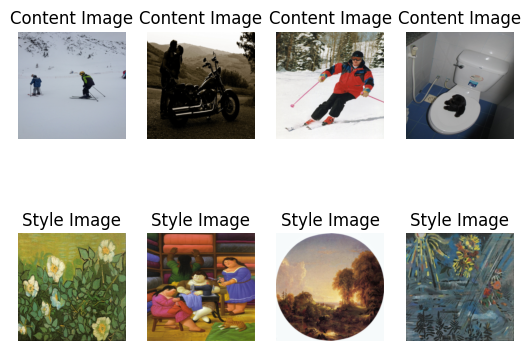

In [47]:
train_index = 0
for content_image, style_image in train_dataloader:
    if train_index == 0:
        for i in range(content_image.shape[0]):
            # 可视化content_image
            plt.subplot(2, 4, i+1)
            plt.imshow(np.transpose(content_image[i], (1, 2, 0)))
            plt.axis('off')
            plt.title('Content Image')

            # 可视化style_image
            plt.subplot(2, 4, i+5)
            plt.imshow(np.transpose(style_image[i], (1, 2, 0)))
            plt.axis('off')
            plt.title('Style Image')

        plt.show()
        break